# Projet Histogram of oriented gradient

ref : https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

https://github.com/JeanKossaifi/python-hog/blob/master/hog/histogram.py

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import itertools
from scipy.ndimage.interpolation import shift

## 1 :  Preprocess the Data

We need to preprocess the image and bring down the width to height ratio to 1:2. The image size should preferably be 64 x 128. This is because we will be dividing the image into 8x8 and 16x16 patches to extract the features. Having the specified size (64 x 128) will make all our calculations pretty simple. In fact, this is the exact value used in the original paper.

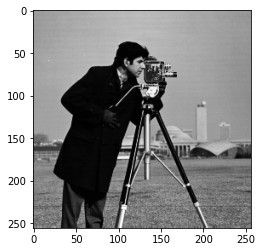

taille de l'image :  (256, 256)


In [11]:
path_base =  'Image/'
image = cv2.imread(path_base+'cameraman.tif',0) 

plt.imshow(image,'gray')
plt.show()
print("taille de l'image : ", image.shape)

In [12]:
dsize= (64,128)
image_resized = cv2.resize(image, dsize, interpolation = cv2.INTER_AREA)

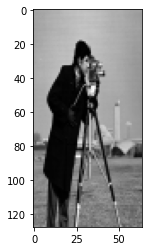

taille de l'image :  (128, 64)


In [13]:
plt.imshow(image_resized,'gray')
plt.show()
print("taille de l'image : ", image_resized.shape)

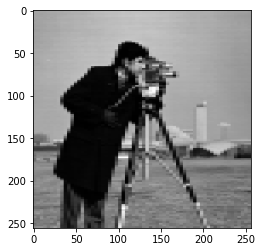

In [14]:
plt.imshow(cv2.resize(image_resized, (256,256), interpolation = cv2.INTER_AREA),'gray')
plt.show()

## 2 : Calculating Gradients (direction x and y)

The next step is to calculate the gradient for every pixel in the image. Gradients are the small change in the x and y directions.

To determine the gradient (or change) in the x-direction, we need to subtract the value on the left from the pixel value on the right. Similarly, to calculate the gradient in the y-direction, we will subtract the pixel value below from the pixel value above the selected pixel.

This process will give us two new matrices – one storing gradients in the x-direction and the other storing gradients in the y direction. 

In [15]:
masque = np.array([[-1,0,1]])

In [16]:
def matrice_x(img, h):
    h_rows,h_cols=h.shape
    rows,cols = img.shape
    large_img = np.zeros((rows+h_rows-1,cols+h_cols-1))
    large_img[h_rows//2:h_rows//2+rows,h_cols//2:h_cols//2+cols]=img
    out_img = np.zeros((rows,cols))
    
    for i in range(rows):
        for j in range(cols):
            out_img[i,j]=np.sum(large_img[i:i+h_rows,j:j+h_cols]*h)
            
    return out_img

In [17]:
def matrice_y(img, h):
    return matrice_x(img, h.T)

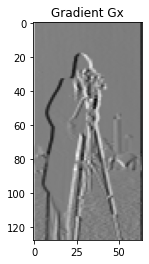

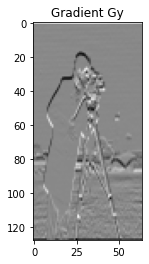

In [18]:
plt.imshow(matrice_x(image_resized, masque), 'gray')
plt.title("Gradient Gx")
plt.show()
plt.imshow(matrice_y(image_resized, masque), 'gray')
plt.title("Gradient Gy")
plt.show()

## 3 : Calculate the Magnitude and Orientation

For this step, we will be using the Pythagoras theorem (ça rappel pleins de souvenirs <3). Voir sur le site internet ça explique bien. Voici les formules : 


Total Gradient Magnitude =  √[(Gx)2+(Gy)2]

Φ = atan(Gy / Gx)

In [19]:
def magnitude_and_orientation(horizontal_gradient,vertical_gradient):
    horizontal_gradient_square = np.power(horizontal_gradient, 2)
    vertical_gradient_square = np.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    grad_magnitude = np.sqrt(sum_squares)
    
    e = 0.00000001
    grad_direction = np.arctan(vertical_gradient/(horizontal_gradient+e))
    grad_direction = np.rad2deg(grad_direction)
    grad_direction = grad_direction%180
    
    return grad_magnitude, grad_direction

m, o = magnitude_and_orientation(matrice_x(image_resized, masque),matrice_y(image_resized, masque))

So now, for every pixel value, we have the total gradient (magnitude) and the orientation (direction). We need to generate the histogram using these gradients and orientations.

## 4 : Calculate Histogram of Gradients

In [20]:
hist_bins = np.array([0,20,40,60,80,100,120,140,160])
hist = np.zeros(9)
rows,cols = image_resized.shape

for i in range(rows):
    for j in range(cols) :
        hist[int(np.floor(o[i,j]/20))] += m[i,j]

In [23]:
def afficher_hist(hist, hist_bins):
    pos = np.arange(len(hist_bins))
    width = 1
    ax = plt.axes()
    ax.set_xticks(pos - (width / 2))
    ax.set_xticklabels(hist_bins)

    plt.bar(pos, hist, width, color='grey', edgecolor="black")
    plt.title("Histogram of Gradients")
    plt.xlabel("Orientation")
    plt.ylabel("Gradient Magnitude")
    plt.show()

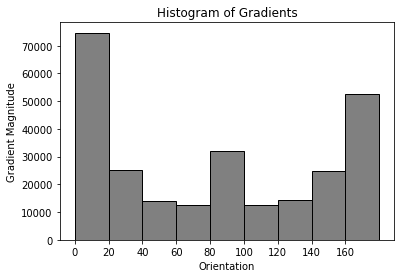

In [24]:
afficher_hist(hist, hist_bins)

## 4 : Calculate Histogram of Gradients in 8×8 cells (9×1)

The histograms created in the HOG feature descriptor are not generated for the whole image. Instead, the image is divided into 8×8 cells, and the histogram of oriented gradients is computed for each cell.

By doing so, we get the features (or histogram) for the smaller patches which in turn represent the whole image. We can certainly change this value here from 8 x 8 to 16 x 16 or 32 x 32.

If we divide the image into 8×8 cells and generate the histograms, we will get a 9 x 1 matrix for each cell.

In [25]:
def histogram_per_cell(img):
    rows,cols = img.shape
    cells = (cols//8)*(rows//8)
    histograms = np.zeros(((rows//8),(cols//8),9))
    
    k = 0
    l = 0
    cell_x = 0
    cell_y = 0

    while True:
        for i in range(8):
            for j in range(8):
                histograms[cell_y, cell_x, int(np.floor(o[i+k,j+l]/20))] += m[i+k,j+l]
        cell_x += 1
        l += 8

        # Si on arrive à 8 fenêtres sur une même ligne :
        # On passe à la ligne d'après (k += 8)
        # Et on revient à la première colonne (l = 0)
        if (l == 64):
            cell_x = 0
            cell_y += 1
            l = 0
            k += 8

        # Si on arrive à la fenêtre en bas à droite alors c'est la fin
        if (k == 128):
            break
    
    return histograms

In [26]:
histograms = histogram_per_cell(image_resized)

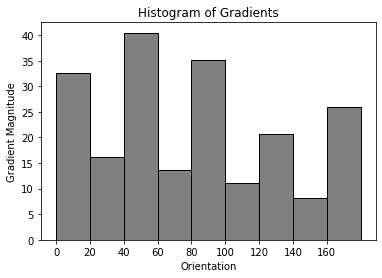

In [80]:
# Histrogramme orienté de la cellule x=1 et y=3
afficher_hist(histograms[1,2,:], hist_bins)

## 5 : Normalize gradients in 16×16 cell (36×1)

Although we already have the HOG features created for the 8×8 cells of the image, the gradients of the image are sensitive to the overall lighting. This means that for a particular picture, some portion of the image would be very bright as compared to the other portions.

We cannot completely eliminate this from the image. But we can reduce this lighting variation by normalizing the gradients by taking 16×16 blocks. 

Here, we will be combining four 8×8 cells to create a 16×16 block. And we already know that each 8×8 cell has a 9×1 matrix for a histogram. So, we would have four 9×1 matrices or a single 36×1 matrix. To normalize this matrix, we will divide each of these values by the square root of the sum of squares of the values. Mathematically, for a given vector V:

V = [a1, a2, a3, ….a36]

We calculate the root of the sum of squares:

k = √(a1)2+ (a2)2+ (a3)2+ …. (a36)2

And divide all the values in the vector V with this value k

In [110]:
def normalise_histogram(histograms, nb_cells_y, nb_cells_x):
    e = 1e-7
    
    # On veut des blocs de 4 fenêtres = 2*2
    bx = 2
    by = 2
    
    n_blocksx = (nb_cells_x - bx) + 1
    n_blocksy = (nb_cells_y - by) + 1
    
    # On a 15 blocs * 7 blocs (les blocs s'entrecroise)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, 9))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = histograms[y:y + by, x:x + bx, :]
            normalised_blocks[y, x, :] = np.clip(block[0, 0, :] / 
                                                    np.sqrt((block**2).sum() + e), 0, 0.2)
            
            k = np.sqrt((normalised_blocks[y, x, :]**2).sum() + e)
            normalised_blocks[y, x, :] /= k


    return normalised_blocks

In [111]:
nb_cells_x = cols//8
nb_cells_y = rows//8

normalised_blocks = normalise_histogram(histograms, nb_cells_y, nb_cells_x)

In [166]:
def final_vector(histograms):
    
    # On veut des blocs de 4 fenêtres = 2*2
    bx = 2
    by = 2
    
    n_blocksx = (nb_cells_x - bx) + 1
    n_blocksy = (nb_cells_y - by) + 1
    
    all_vector = np.zeros((n_blocksy, n_blocksx, 36))
    vector = np.zeros(36)
    
    for x in range(n_blocksx):
        for y in range(n_blocksy):
            
            all_vector[y,x,0:9] = histograms[y,x,:]
            all_vector[y,x,9:18] = histograms[y,x+1,:]
            all_vector[y,x,18:27] = histograms[y+1,x,:]
            all_vector[y,x,27:36] = histograms[y+1,x+1,:]
            
            somme_carre = 0
            for i in range(36):
                somme_carre += all_vector[y,x,i]**2
                
            k = np.sqrt(somme_carre)
            
            all_vector[y,x,:] = all_vector[y,x,:]/k
    
    return all_vector

all_vector = final_vector(histograms)
all_vector.shape

(15, 7, 36)

On a maintenant 15x7 = 105 blocs normalisés !

Chacun de ses blocs contient 9x4 = 36 caractéristiques d'orientation et de magnitude. (9 = bins (degrés) et 4 = nombres de fenêtre par bloc)

Au total on a 105x36 = 3780 caractéristiques ! 

## 6. Features for the complete image

In [169]:
from skimage import draw

def afficher_image(vector):
    
    image_hog = np.zeros((128,64))
    
    for x in range(8):
        for y in range(16):
            
            
    
    return image_hog

IndentationError: expected an indented block (<ipython-input-169-e020598c4881>, line 12)

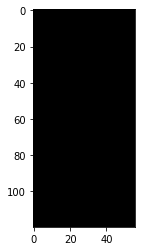

In [170]:
image_hog = afficher_image(all_vector)
plt.imshow(image_hog, 'gray')
plt.show()

## Fin : réponse à avoir

In [268]:
from skimage.feature import hog

fd, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

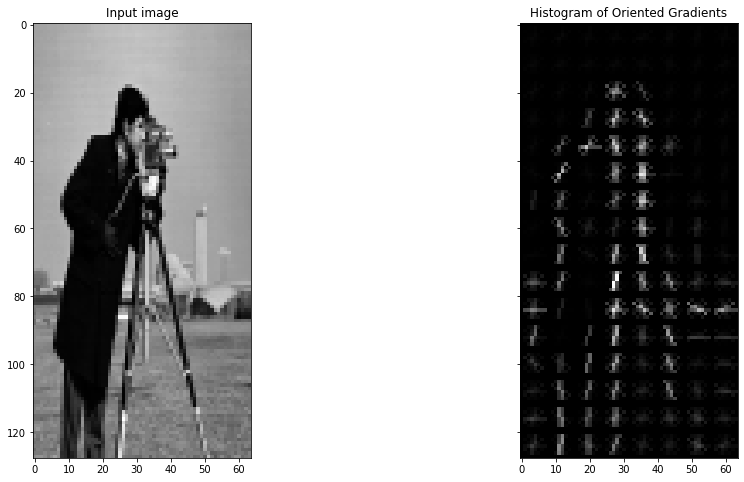

In [269]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(image_resized, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

ax2.imshow(hog_image, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()